In [2]:
%matplotlib inline
%config Completer.use_jedi = False

In [3]:
import os
import numpy as np

import xarray as xr

from pathlib import Path 
import salvus.namespace as sn
from salvus.flow import simple_config as config

import salvus.mesh.unstructured_mesh as um
import salvus.mesh.structured_grid_2D as sg2d

import salvus.namespace as sn

import matplotlib.pyplot as plt

SALVUS_FLOW_SITE_NAME=os.environ.get('SITE_NAME','local')


In [4]:
#Import the model - Relative Permittivity values

file = "vel1_copy.bin"

dt = np.dtype([('time', '<u2'),('time1', '<u2'),('time2', np.float32),('time3', np.float32)])

data = np.fromfile(file, dtype=np.float32, count=-1, sep='', offset=0)

array_eps_rel = data.reshape (3000,3000) 

print(array_eps_rel)
#print(my_array_eps_rel[1500,1500])
#print(my_array_eps_rel[2999,2999])
#print(my_array_eps_rel[1700,1700])
#print(data)
#type(data)

[[ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 ..., 
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]
 [ 0.299  0.299  0.299 ...,  0.299  0.299  0.299]]


In [5]:
#Density
array_rho = np.full((3000,3000),1000, dtype=int)
print(array_rho)

[[1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]
 ..., 
 [1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]
 [1000 1000 1000 ..., 1000 1000 1000]]


In [6]:
#Magnetic Permeability
array_mu = np.full((3000,3000),1, dtype=int)
print(array_mu)

[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


In [7]:
import math

c = 3e8 #speed of light
mu = 1
#v_radar = c / math.sqrt(mu * array_eps_rel)

array_eps_rel_sqrt=np.sqrt(array_eps_rel)
print(array_eps_rel_sqrt)

v_radar = c / (mu * array_eps_rel_sqrt)
print(v_radar)

#or

#v_radar_1 = np.divide(c, array_eps_rel_sqrt) 
#print(v_radar_1)


[[ 0.5468089  0.5468089  0.5468089 ...,  0.5468089  0.5468089  0.5468089]
 [ 0.5468089  0.5468089  0.5468089 ...,  0.5468089  0.5468089  0.5468089]
 [ 0.5468089  0.5468089  0.5468089 ...,  0.5468089  0.5468089  0.5468089]
 ..., 
 [ 0.5468089  0.5468089  0.5468089 ...,  0.5468089  0.5468089  0.5468089]
 [ 0.5468089  0.5468089  0.5468089 ...,  0.5468089  0.5468089  0.5468089]
 [ 0.5468089  0.5468089  0.5468089 ...,  0.5468089  0.5468089  0.5468089]]
[[  5.48637760e+08   5.48637760e+08   5.48637760e+08 ...,   5.48637760e+08
    5.48637760e+08   5.48637760e+08]
 [  5.48637760e+08   5.48637760e+08   5.48637760e+08 ...,   5.48637760e+08
    5.48637760e+08   5.48637760e+08]
 [  5.48637760e+08   5.48637760e+08   5.48637760e+08 ...,   5.48637760e+08
    5.48637760e+08   5.48637760e+08]
 ..., 
 [  5.48637760e+08   5.48637760e+08   5.48637760e+08 ...,   5.48637760e+08
    5.48637760e+08   5.48637760e+08]
 [  5.48637760e+08   5.48637760e+08   5.48637760e+08 ...,   5.48637760e+08
    5.48637760e+08

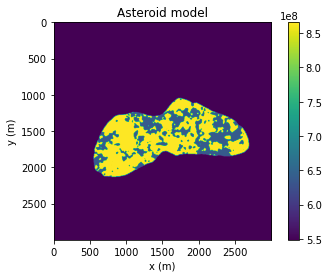

In [8]:
plt.imshow(np.rot90(v_radar,3))
plt.title('Asteroid model')
plt.colorbar(orientation='vertical')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

#plt.figure(figsize=(16, 6))

#plt.subplot(121)
#true_model.vp.T.plot()
#plt.subplot(122)
#true_model.rho.T.plot()

plt.show()

In [9]:
def my_model():
    nx, nz = 3000, 3000
    x = np.linspace(-500, +500, nx)
    y = np.linspace(-500, +500, nx)
    xx, yy = np.meshgrid(x, y, indexing = "ij")
    
    #put the array elements into the appropriate part of the model xarray structure
    ds = xr.Dataset ( data_vars= {"vp": (["x", "y"], v_radar),  "rho": (["x", "y"], array_rho),}, coords={"x": x, "y": y},)
    
    #ds['vp'] *=10e9 #10e9
    return ds

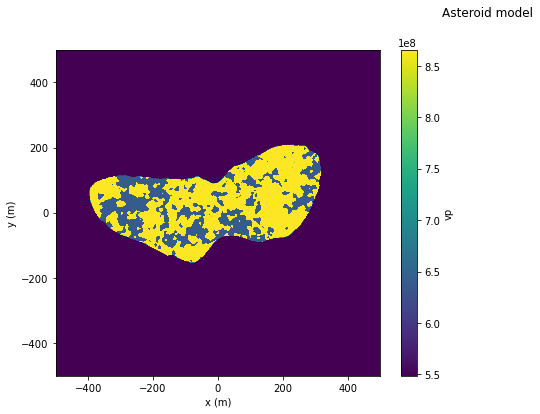

In [10]:
true_model = my_model()

# Plot the xarray dataset.
plt.figure(figsize=(16, 6))

plt.subplot(121)
true_model.vp.T.plot()
plt.xlabel("x (m)")
plt.ylabel("y (m)")

plt.suptitle("Asteroid model")
plt.show()

In [11]:
import pathlib
!rm -rf project
if pathlib.Path("project").exists():
    print("Opening existing project.")
    p = sn.Project(path="project")
else:
    print("Creating new project.")
    vm = sn.model.volume.cartesian.GenericModel(
        name="true_model_EM", data=true_model
    )
    p = sn.Project.from_volume_model(path="project", volume_model=vm)

Creating new project.


In [12]:
wavelet=sn.simple_config.stf.Ricker(center_frequency=15.0e6)
mesh_frequency = wavelet.center_frequency

srcs = sn.simple_config.source.cartesian.ScalarPoint2D( 
     source_time_function=wavelet, x=0.0, y=450.0, f=1)


recs = sn.simple_config.receiver.cartesian.collections.RingPoint2D(
       x=0, y=0, radius=450, count=380, fields=["phi"])
    
p += sn.EventCollection.from_sources(sources=srcs, receivers=recs)

[2021-01-27 15:19:38,380] INFO: A source for event `event_0000` has a source time function. Events in the project cannot have a source time function (they are frequency dependent). The source time function has thus been stripped.


In [13]:
from salvus.toolbox import toolbox

num_absorbing_layers = 10
absorbing_side_sets = ["x0", "x1", "y0", "y1"]

mesh = toolbox.mesh_from_xarray(
    model_order=4,
    data=true_model,
    slowest_velocity='vp',
    maximum_frequency=mesh_frequency,
    elements_per_wavelength=2,
    absorbing_boundaries=(absorbing_side_sets, num_absorbing_layers)) 

In [14]:
mesh

In [15]:
sim = config.simulation.Waveform (mesh=mesh,sources=srcs,receivers=recs)

In [16]:
sim

In [17]:
#wsc = sn.WaveformSimulationConfiguration(start_time_in_seconds=1e-9)
wsc = sn.WaveformSimulationConfiguration(end_time_in_seconds=9.5e-6)
wsc.physics.wave_equation.time_step_in_seconds = 1.0e-10

In [18]:
ec = sn.EventConfiguration(
    waveform_simulation_configuration=wsc,
    wavelet=sn.simple_config.stf.Ricker(center_frequency=20.0e6),
)


p += sn.SimulationConfiguration(
    name="true_model_new_EM",
    elements_per_wavelength=1.5,
    tensor_order=4,
    max_frequency_in_hertz=mesh_frequency,
    model_configuration=sn.ModelConfiguration(
        background_model=None, volume_models="true_model_EM"
    ),
    # Potentially event dependent settings.
    event_configuration=ec,
)

In [19]:
p.simulations.launch(
    simulation_configuration="true_model_new_EM",
    events=p.events.get_all(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=1,

)

[2021-01-27 15:19:59,026] INFO: Creating mesh. Hang on.
[2021-01-27 15:20:04,497] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2101271520791556_28463dd86c@local


1

In [20]:
p.simulations.query(block=True)

VBox()

True

In [21]:
p.simulations.get_mesh("true_model_new_EM")

In [22]:
true_data = p.waveforms.get(
    data_name="true_model_new_EM", events=p.events.get_all()
)

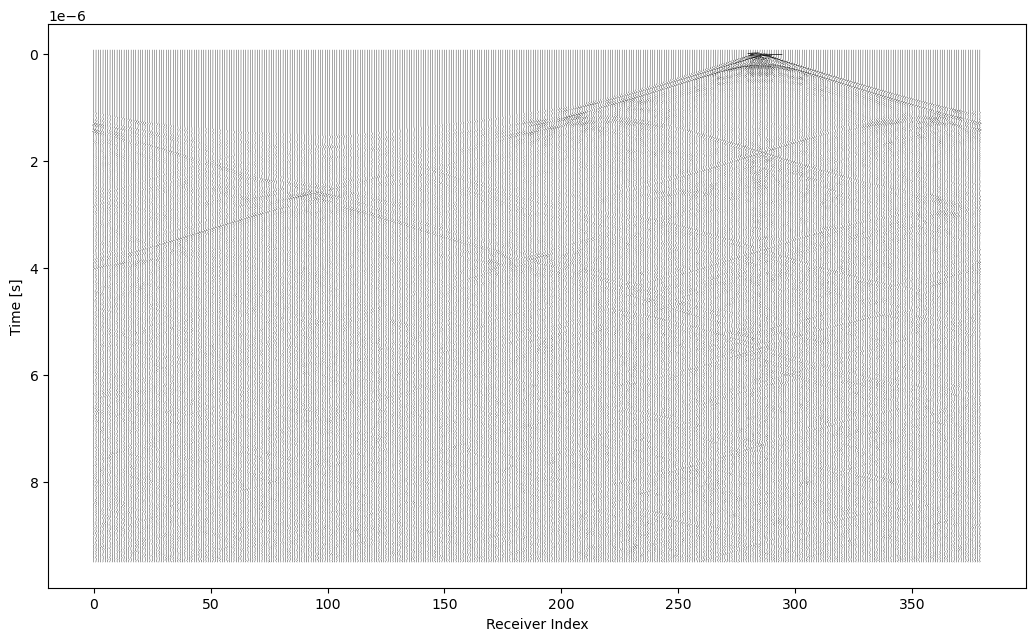

In [23]:
true_data[0].plot(component="A", receiver_field="phi")


In [29]:
p.viz.nb.waveforms(
    ["true_model_new_EM"], receiver_field="phi")